# The RBM flow and the Critical Temperature of Ising Models

This notebook contains the main discussion for $L=11$.

First, we import the necessary Python packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import seaborn as sns

import torch
import torch.nn as nn
torch.manual_seed(12)

import sys
# sys.path.append('/modules')
from mc_ising2d import IsingMC
from net import Net
from rbm_L11 import RBM

Tc_Ons = 2 / ( np.log(1 + np.sqrt(2)) )
Tc_MF = 4.0


In [2]:
L = 11

The neural network thermometer is called by the following function.

In [3]:
def thermometer(flow_,
                ising_data,
                L= L,
                x= 0,
                step= 2,
                save= False,
                Tzero= True, 
                x_text= 0,
                y_text= 0.15,
                errorbar= True,
                publication= False,
                training_set= 'COMPLETE',
                loc_legend= 'lower right',
                NN_path= f'L{L}_NN_Ising2D_MC.pt'): # this points to the trained NN thermometer
    
    net = Net()
    net = torch.load(NN_path)  
    
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize= 4.0
        linewidth= 0.8
        fontsize_l= 12.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
       
    for j in range(0, len(flow_) - x, step):
        
        prediction = net(flow_[j])
        
        if errorbar:
                   
            plt.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= 'x',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j )
            
        else:
            
            plt.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= 'x',
                     markersize= markersize,
                     linewidth= linewidth,
                     label= 'It = %d' % j )
        
        
        plt.axvline(x= Tc_Ons, linestyle= ':', linewidth= 0.8, color= 'black')
        
        plt.xlabel('Temperature scale', fontsize= fontsize_l)
        plt.ylabel('Softmax probability', fontsize= fontsize_l)
        
    plt.legend(fontsize= fontsize_lg,
               loc= loc_legend)
    
    if Tzero:
        plt.text(x= x_text, y= y_text, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        plt.text(x= x_text, y= y_text, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if Tzero:
            if publication:
                path_fig = 'PUB_flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig, bbox_inches='tight')
        else:
            if publication:
                path_fig = 'PUB_flow_L%d_Train%s_ONLY_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'flow_L%d_ONLY_Train%s_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
                           
    plt.show()

We also define the function `thermometer_joint_plot`, which can plot two different flows in the same figure.

The thermometer function is a plotting utility to visualise the behaviour of a neural network (loaded from a file) on Ising model data. It can generate plots either for publications or for general use.

Loading Model: The function starts by loading a pre-trained neural network model from a given path (NN_path).

Plotting Setup: Depending on whether the plot is intended for publication (publication=True), it sets different attributes like font size, line width, etc.

Data Loop: It loops through the data (flow_) and uses the neural network to make predictions. These predictions are then plotted.

Error Bars: The option to include error bars in the plot is controlled by the errorbar flag.

Annotations: Additional plot elements like vertical lines, labels, and text annotations are added.

Save Plot: The plot can be saved to a file if the save flag is set to True.

Show Plot: Finally, the plot is displayed using plt.show().

By doing this, the function aims to provide an insight into how well the neural network has learned to predict features of the Ising model over different temperatures.

In [4]:
def thermometer_joint_plot(flow_1,
                           flow_2,
                           ising_data= None,
                           L= L,
                           x1= 0,
                           x2= 0,
                           step1= 2,
                           step2= 2,
                           save= False,
                           Tzero1= True,
                           Tzero2= True,
                           x_text1= 0,
                           y_text1= 0.15,
                           x_text2= 0,
                           y_text2= 0.15,
                           errorbar1= False,
                           errorbar2= True,
                           publication= False,
                           ref_other_plot= False,
                           step1_ref_other= 2,
                           step2_ref_other= 2,
                           training_set= 'COMPLETE',
                           loc_legend1= 'lower right',
                           loc_legend2= 'lower right',
                           NN_path= f'L{L}_NN_Ising2D_MC.pt'):
    # Load the neural network model
    net = Net()
    net = torch.load(NN_path) 
    
    if publication:
        fig = plt.figure(figsize=(3.375, 
                                  2*0.678*3.375))
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_ticks = 6.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.5
        
        if save:
            if errorbar1 == errorbar2:
                path_fig = 'PUB_flow_L%d_Train%s_TinZERO_and_TinINF_errobar_both%s.pdf' % (L,
                                                                                                   training_set,
                                                                                                   str(errorbar1))
            else:
                path_fig = 'PUB_flow_L%d_Train%s_TinZERO%s_errobar_plot2_%s.pdf' % (L,
                                                                                            training_set,                                                                                                   
                                                                                            str(Tzero1), 
                                                                                            str(errorbar2))
                
        
    else:
        fig = plt.figure(figsize=(plt.rcParams.get('figure.figsize')[0],
                                  2*plt.rcParams.get('figure.figsize')[1]))
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 10.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
        linewidth_v= 0.8
        
        if save:
            if errorbar1 == errorbar2:
                path_fig = 'flow_L%d_Train%s_TinZERO_and_TinINF_errobar_both%s.pdf' % (L,
                                                                                               training_set,
                                                                                               str(errorbar1))
            else:
                path_fig = 'flow_L%d_Train%s_TinZERO%s_errobar_plot2_%s.pdf' % (L, 
                                                                                        training_set,
                                                                                        str(Tzero1), 
                                                                                        str(errorbar2))
        
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
        
    ### ax1 plot
    
    color_counter = 0
       
    for j in range(0, len(flow_1) - x1, step1):
        
        prediction = net(flow_1[j])
        
        if errorbar1:
                   
            ax1.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j,
                         color= 'C%d' % color_counter)
            
        else:
            
            ax1.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize - 1.0,
                     linewidth= linewidth,
                     label= 'It = %d' % j,
                     color= 'C%d' % color_counter)
            
        if ref_other_plot:
            
            if step1 >= step1_ref_other:
                ps = step1 / step1_ref_other
            else:
                ps = 1
        else:
            ps = 1
            
        color_counter = color_counter + int(ps)
        
        ax1.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
        
        ax1.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax1.legend(fontsize= fontsize_lg,
               loc= loc_legend1)
    
    if Tzero1:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax1.set_ylim(0.0, ax1.set_ylim()[1])
    if publication:
        ax1.tick_params(axis="y", labelsize= fontsize_ticks)
        ax1.tick_params(axis="x", labelsize= fontsize_ticks)
    ax1.set_xticklabels([])
    
    ### ax2 plot
    
    color_counter = 0
       
    for j in range(0, len(flow_2) - x2, step2):
        
        prediction = net(flow_2[j])
        
        if errorbar2:
                   
            ax2.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j,
                         color= 'C%d' % color_counter)
            
        else:
            
            ax2.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize - 1.0,
                     linewidth= linewidth,
                     label= 'It = %d' % j, 
                     color= 'C%d' % color_counter)
            
        if ref_other_plot:
            
            if step2 >= step2_ref_other:
                ps = step2 / step2_ref_other
            else:
                ps = 1
        else:
                        
            if step2 >= step1:
                ps = step2 / step1
            else:
                ps = 1
            
        color_counter = color_counter + int(ps)
        
        
        ax2.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
        
        ax2.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax2.legend(fontsize= fontsize_lg,
               loc= loc_legend2)
    
    if Tzero2:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0  =\infty$', fontsize= fontsize_t)

    ax2.set_ylim(0.0, ax2.set_ylim()[1])
    
    if publication:
        ax2.tick_params(axis="y", labelsize= fontsize_ticks)
        ax2.tick_params(axis="x", labelsize= fontsize_ticks)

    ax2.sharex(ax1)

    plt.subplots_adjust(hspace=.05)

    plt.xlabel('Temperature scale', fontsize= fontsize_l)

    if save:
        plt.savefig(path_fig , bbox_inches='tight')

    plt.show()

The magnetization can be also be analyzed during flow dynamics.

In [5]:
def magnetization(flow_low,
                  flow_high,
                  L= L,
                  errorbar= True,
                  fill_error= False, 
                  Tzero= True,
                  x= 0, 
                  step= 1,
                  loc_legend= 'lower right',
                  training_set= 'COMPLETE',
                  save= False, 
                  publication= False):
              
    mag_low= []
    er_bar_low= []
    x_axis= [] 
    
    for j in range(0, len(flow_low)- x, step):
        flow = 2*flow_low[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_low.append(mag.item())
        er_bar_low.append(error_bar.item())
        x_axis.append(j)
        
    mag_high= []
    er_bar_high= []
        
 
    for j in range(0, len(flow_high)- x, step):
        flow = 2*flow_high[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_high.append(mag.item())
        er_bar_high.append(error_bar.item())
  

    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.4
        color_h = 'black'
        
    else:
        markersize = 10.0
        linewidth= 0.8
        fontsize_l = 12.0
        fontsize_t = 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth = 0.5
        linewidth_v= 0.8
        color_h= 'black'
        
    if errorbar:
                                                 
        plt.errorbar(x_axis,
                     mag_low,
                     yerr= er_bar_low,
                     label= '$T_{0}=0$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
        
        plt.errorbar(x_axis,
                     mag_high,
                     yerr= er_bar_high,
                     label= '$T_{0}  = \infty$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
   
    else:
        
        plt.plot(x_axis, 
                 mag_low,
                 label= '$T_{0}=0$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        if fill_error:
            plt.fill_between(np.array(x_axis), 
                             np.array(mag_low) - np.array(er_bar_low),
                             np.array(mag_low) + np.array(er_bar_low),
                             alpha= 0.1)
            
        
        plt.plot(x_axis, 
                 mag_high,
                 label= '$T_{0} = \infty$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        if fill_error:
            plt.fill_between(np.array(x_axis), 
                             np.array(mag_high) - np.array(er_bar_high),
                             np.array(mag_high) + np.array(er_bar_high),
                             alpha= 0.1)
        
    plt.xlabel('Flow iteration', fontsize= fontsize_l)
    plt.ylabel('$m$', fontsize= fontsize_l)
    
    plt.legend(fontsize= fontsize_t,
               loc= loc_legend)
    
    m_fp = mag_high[-1]
    
    plt.axhline(y= m_fp, linestyle= ':', linewidth= linewidth_v, color= color_h)
    
    m_fp = round(m_fp, 5)
    #plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if publication:
            if fill_error:
                path_fig = 'PUB_mag_flow_L%d_Train%s_erfilled_mfp%s.pdf' % (L, 
                                                                                    training_set,
                                                                                    str(m_fp).replace('.',''))
            else:
                path_fig = 'PUB_mag_flow_L%d_Train%s_erbar_mfp%s.pdf' % (L, 
                                                                                 training_set,
                                                                                 str(m_fp).replace('.',''))
                
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            if fill_error:
                path_fig = 'mag_flow_L%d_Train%s_erfilled_mfp%s.pdf' % (L,
                                                                                training_set,
                                                                                str(m_fp).replace('.',''))
            else:
                path_fig = 'mag_flow_L%d_Train%s_erbar_mfp%s.pdf' % (L, 
                                                                             training_set,
                                                                             str(m_fp).replace('.',''))
                
            plt.savefig(path_fig, bbox_inches='tight')
    
    plt.show()
    
    print('m^{*} = %f' % m_fp)

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L11_Ising2D_MC.pkl` was constructed considering a square lattice $L\times L$, with $L=11$. There are 1000 spins configurations for each of 25 different temperatures $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.75, 6 $.

In [6]:
ising_data = pd.read_pickle(f'L{L}_Ising2D_MC.pkl')
ising_data.head()

,state,magn,energy,temp
0,"[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ...",5,-58,6.0
1,"[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...",5,-42,6.0
2,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...",19,-62,6.0
3,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...",9,-54,6.0
4,"[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, ...",7,-2,6.0


In [7]:
my_ising_data = pd.read_pickle('my_2d_ising_data.pkl')
my_ising_data.head()

,state,magn,energy,temp
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,-200.0,0.000001
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,-200.0,0.000001
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,-200.0,0.000001
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,-200.0,0.000001
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",100.0,-200.0,0.000001


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


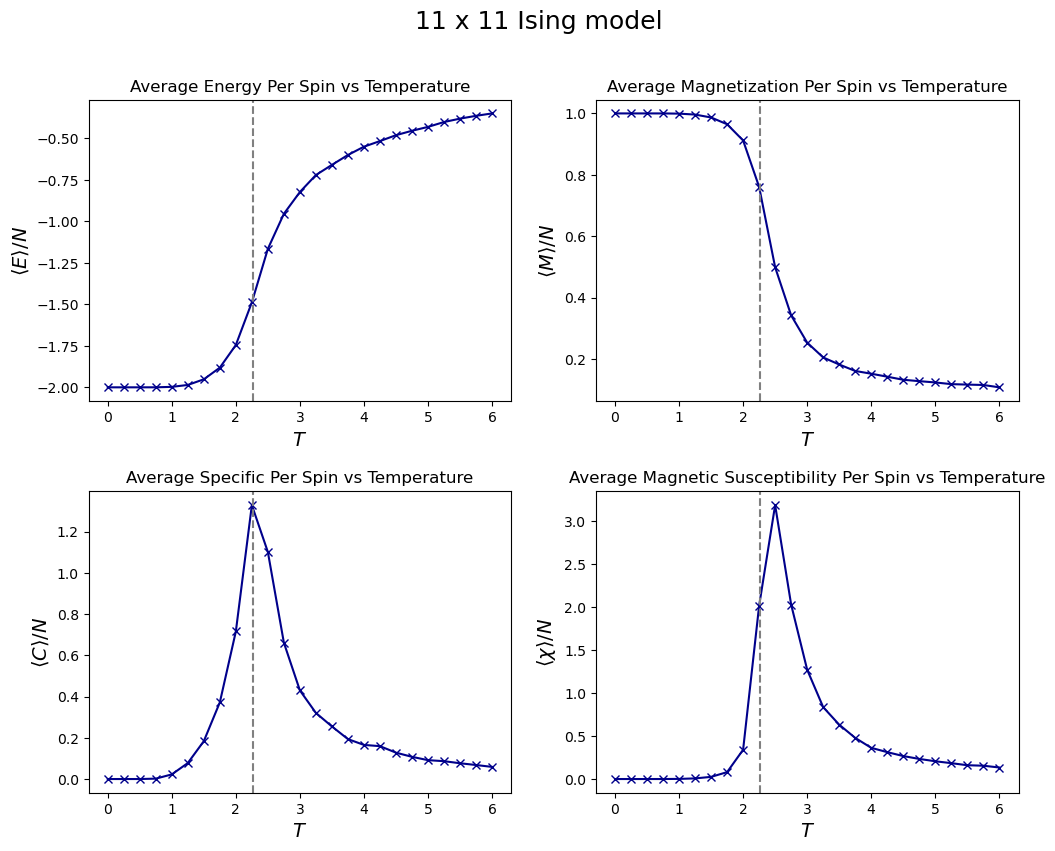

In [8]:
IsingMC(L= L).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

# ALL GOOD AND DONE UP TO HERE

## RBM flows

### Flow from RBM trained with 25 different temperatures

First we load the trained RBM model.

In [9]:
#rbm = RBM()
#rbm = torch.load(f'RBM_L{L}_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs8000.pt')

In [10]:
rbm100 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs100.pt'))

In [11]:
rbm200 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs200.pt'))

In [12]:
rbm400 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs400.pt'))

In [13]:
rbm800 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs800.pt'))

In [14]:
rbm1600 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs1600.pt'))

In [15]:
rbm3200 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs3200.pt'))

In [16]:
rbm6400 = torch.load(('RBM_L11_model_T_complete_nv121_nh121_lr1.0E-02_k1_bsize100_nepochs6400.pt'))

For the sake of completeness, we take a look at the weights distribution.

In [112]:
W, v, h = rbm.parameters() # get parameters W, v, h from the trained RBM

del v # delete variable v to free memory
del h # delete variable h to free memory
torch.cuda.empty_cache() # clear unused memory from GPU

In [113]:
np.shape(W)

torch.Size([100, 100])

In [114]:
W_layers = rbm.W_layers()

AttributeError: 'RBM' object has no attribute 'W_layers'

In [115]:
len(W_layers)

NameError: name 'W_layers' is not defined

we have a list of tensors, each tensor is a W

In [13]:
type(W_layers)

list

### Calc $WW^T$ for each $W$ in $W -layers$

In [14]:
WWt_list = [W @ W.T for W in W_layers]  

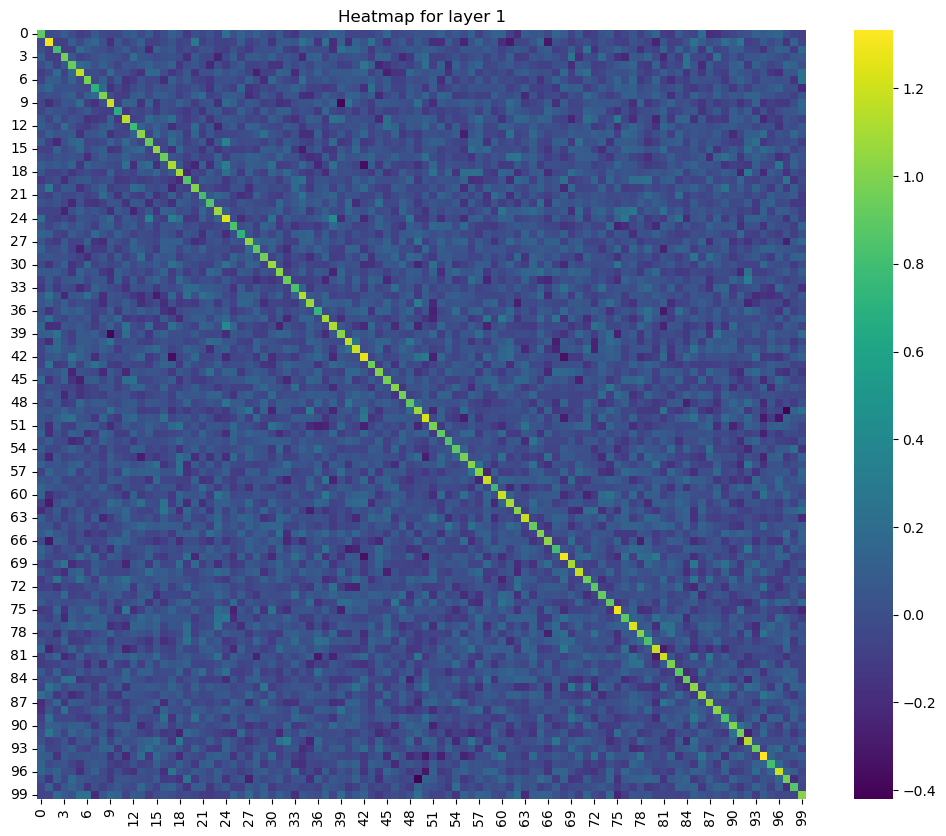

In [15]:
# Set the indices for the layers you want to plot, e.g., every 1000th layer up to 8000
indices_to_plot = range(0, len(WWt_list), 1000)

# Calculate the number of rows/cols for your grid
total_plots = len(range(0, len(W_layers), 1000))  # How many layers you'll plot
cols = 3  # You can choose a different value if you prefer
rows = total_plots // cols + (total_plots % cols > 0)  # Calculate rows needed for the subplot

fig, axs = plt.subplots(rows, cols, figsize=(cols * 10, rows * 8))  # Adjust size as needed

# Flatten the array of axes if it's multidimensional
axs = axs.flatten()

# Now plot each layer's heatmap
for index, layer_index in enumerate(indices_to_plot):
    # Convert tensor to numpy if it's not already on CPU and in numpy form
    matrix_to_plot = WWt_list[layer_index].cpu().numpy() if WWt_list[layer_index].is_cuda else WWt_list[layer_index].numpy()
    sns.heatmap(matrix_to_plot, ax=axs[index], cmap='viridis', square=True)
    axs[index].set_title(f"Heatmap for layer {layer_index + 1}")

# Hide any unused subplots
for i in range(index + 1, len(axs)):
    axs[i].set_visible(False)

plt.tight_layout()
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

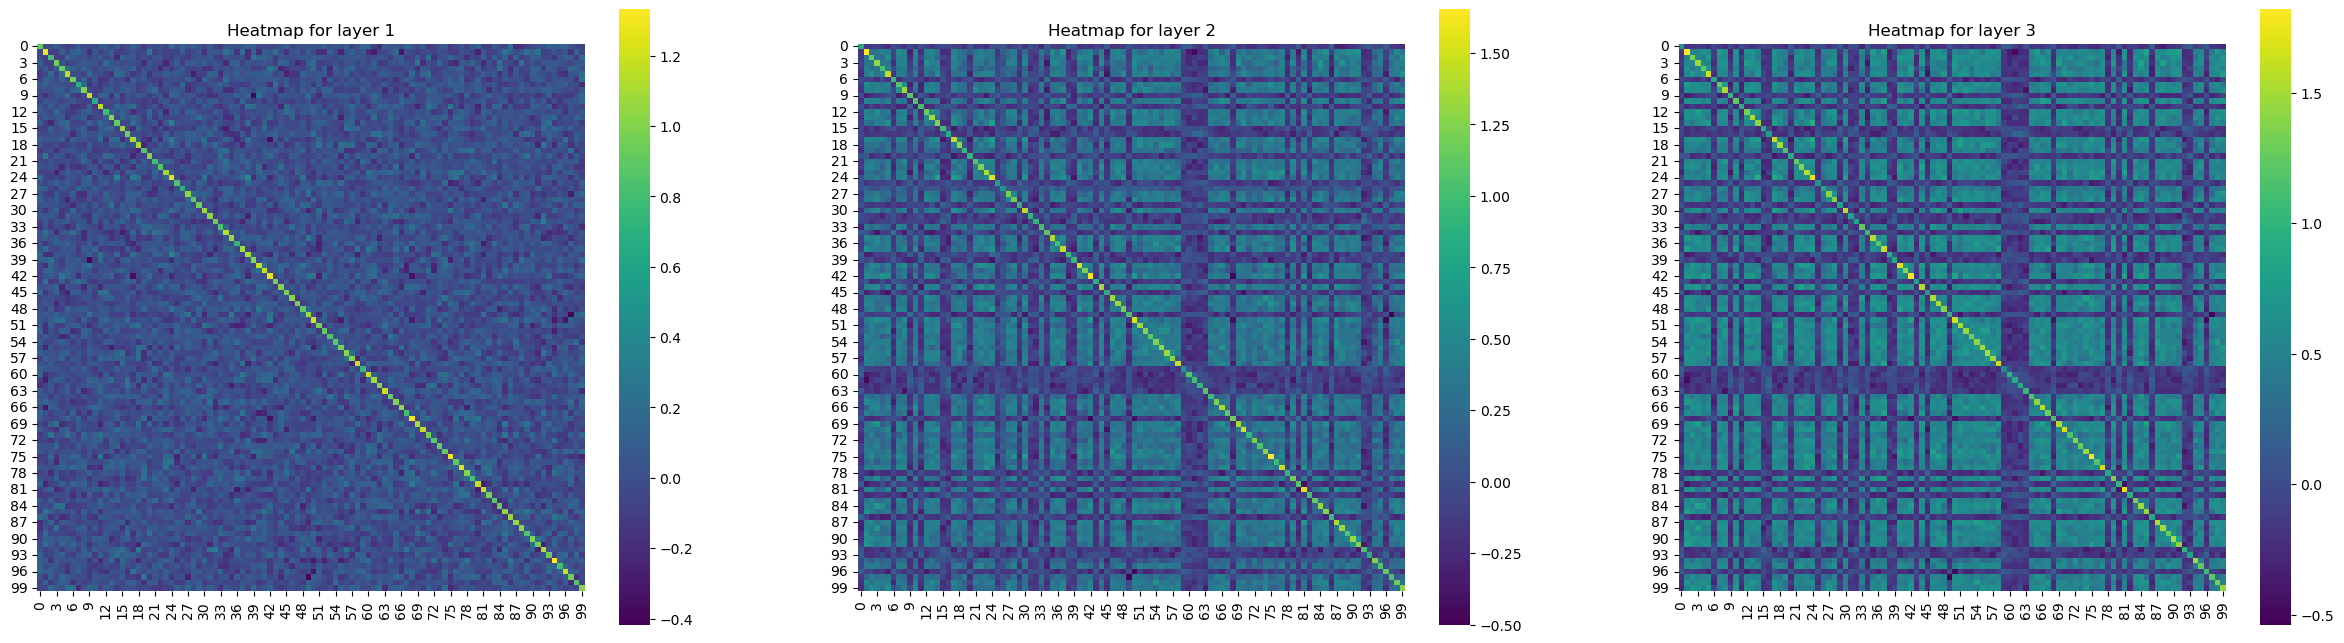

In [16]:
# Set the indices for the layers you want to plot, e.g., every 1000th layer up to 8000
indices_to_plot = range(0, 9)

# Calculate the number of rows/cols for your grid
total_plots = len(range(0, len(W_layers), 1000))  # How many layers you'll plot
cols = 3  # You can choose a different value if you prefer
rows = total_plots // cols + (total_plots % cols > 0)  # Calculate rows needed for the subplot

fig, axs = plt.subplots(rows, cols, figsize=(cols * 10, rows * 8))  # Adjust size as needed

# Flatten the array of axes if it's multidimensional
axs = axs.flatten()

# Now plot each layer's heatmap
for index, layer_index in enumerate(indices_to_plot):
    # Convert tensor to numpy if it's not already on CPU and in numpy form
    matrix_to_plot = WWt_list[layer_index].cpu().numpy() if WWt_list[layer_index].is_cuda else WWt_list[layer_index].numpy()
    sns.heatmap(matrix_to_plot, ax=axs[index], cmap='viridis', square=True)
    axs[index].set_title(f"Heatmap for layer {layer_index + 1}")

# Hide any unused subplots
for i in range(index + 1, len(axs)):
    axs[i].set_visible(False)

plt.tight_layout()
plt.show()

Bars: The histogram bars represent the frequency distribution of the reshaped weights. They show how often different weight values occur in the reshaped weight matrix W_.

Orange Line: The orange line represents the fitted normal distribution for these reshaped weights (W_). It's a theoretical model showing what the distribution of weights would look like if they perfectly followed a normal distribution with mean muW_V and standard deviation sigmaW_V.

There's no visual representation of the actual 2D weight matrix W in the plot; it has been reshaped to 1D (W_) for this analysis.

The orange line is calculated by fitting a normal distribution to the reshaped weights (W_). This is done by finding the mean (muW_V) and standard deviation (sigmaW_V) of W_. The line represents the probability density function (PDF) of this fitted normal distribution across the domain.

In [11]:
# convert tensor W to NumPy array and reshape it into 1D array
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1])) 

# Plot normalized histogram of reshaped weights
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])
# Generate an array of equally spaced values within this range
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution to the reshaped weights
muW_V, sigmaW_V = stats.norm.fit(W_) 

# compute probability density function for the fitted nomral distribution
plot_pdf = stats.norm.pdf(domain, muW_V, sigmaW_V) # Fitting the PDF in the interval

# plot the PDF on the existing histogram
plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_V, sigmaW_V ))

# add title and axis limiations
plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-6, 6])
plt.legend()
plt.show()

NameError: name 'W' is not defined

We can also take a look at the matrix ${\cal W} {\cal W}^{T}$:

The next block of code computes the matrix product of the transposed weight matrix W.t() and the weight matrix W, storing the result in WW. Then it creates a heatmap of WW using the Seaborn library.

What it's doing:
WW = torch.mm(W.t(), W) computes the square of the matrix norms and captures the relationships between different features in the weight matrix.
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis') visualises this as a heatmap.
What we can understand:
Feature Correlation: The heatmap can show if certain features (columns in W) are correlated. Strongly correlated features will result in bright spots on the heatmap.
Matrix Structure: Diagonal elements represent the "importance" of individual features as they are the square of the norms of the columns in W.
Complexity: A uniform heatmap may suggest that the model has not learned well or that all features contribute equally, while varying intensities may imply a well-trained model with features of varying importance.
The heatmap of WW provides a different kind of insight into the weight matrix compared to the distribution fitting, focusing on feature relationships and model complexity.

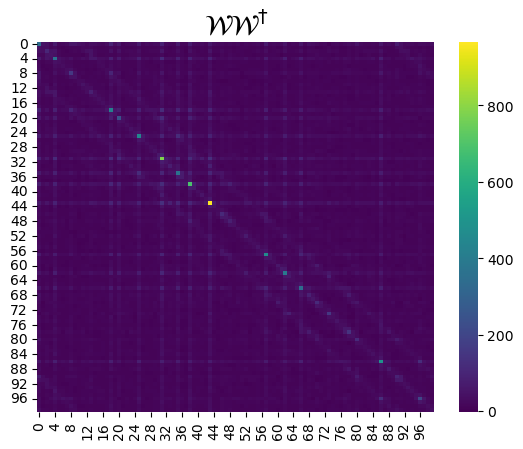

In [18]:
# compute the matrix product of W transposed and W, store in WW
WW = torch.mm(W.t(), W)
# create a heatmap using seaborn library
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
# add title to the heatmap
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
# show the heatmap
plt.show()

In [19]:
del W # delete the variable W to free memory
torch.cuda.empty_cache() # clear unused memory from the GPU

#### Initial temperature: $T_0= 0$

The v0 tensor is being initialised to serve as the initial states for the Restricted Boltzmann Machine (RBM) flow algorithm. The tensor has a shape of (n_states, L*L), which suggests it represents n_states (1000 in this case) individual states, each of size L*L. All these states are initialised to a constant value of 1.0.

The exact nature of these states depends on the specific problem being addressed by the RBM, but generally, they could represent initial configurations or initial feature vectors that the RBM will further process or transform

In [17]:
n_states = 1000 # set the number of states to 1000 (1000 seperate visible states)
# initialise a tensor v0 of shape (n states, L*L) with constant value 1.0
v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [18]:
flow100 = rbm100.flow(n_it_flow= 40, vk= v0)
with open('rbm_flow_L11_ALL_Tin_zero_100.pkl', 'wb') as f:
    pickle.dump(flow100, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_100.pkl', 'rb') as f:
    flow100 = pickle.load(f)

flow_100 = [ x for x in flow100 ]

In [19]:
flow200 = rbm200.flow(n_it_flow= 40, vk= v0)
with open('rbm_flow_L11_ALL_Tin_zero_200.pkl', 'wb') as f:
    pickle.dump(flow200, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_200.pkl', 'rb') as f:
    flow200 = pickle.load(f)

flow_200 = [ x for x in flow200 ]

In [20]:
flow400 = rbm400.flow(n_it_flow= 40, vk= v0)
with open('rbm_flow_L11_ALL_Tin_zero_400.pkl', 'wb') as f:
    pickle.dump(flow400, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_400.pkl', 'rb') as f:
    flow400 = pickle.load(f)

flow_400 = [ x for x in flow400 ]

In [21]:
flow800 = rbm800.flow(n_it_flow= 40, vk= v0)

with open('rbm_flow_L11_ALL_Tin_zero_800.pkl', 'wb') as f:
    pickle.dump(flow800, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_800.pkl', 'rb') as f:
    flow800 = pickle.load(f)

flow_800 = [ x for x in flow800 ]

In [22]:
flow1600 = rbm1600.flow(n_it_flow= 40, vk= v0)

with open('rbm_flow_L11_ALL_Tin_zero_1600.pkl', 'wb') as f:
    pickle.dump(flow1600, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_1600.pkl', 'rb') as f:
    flow1600 = pickle.load(f)

flow_1600 = [ x for x in flow1600 ]

In [23]:
flow3200 = rbm3200.flow(n_it_flow= 40, vk= v0)

with open('rbm_flow_L11_ALL_Tin_zero_3200.pkl', 'wb') as f:
    pickle.dump(flow3200, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_3200.pkl', 'rb') as f:
    flow3200 = pickle.load(f)

flow_3200 = [ x for x in flow3200 ]

In [24]:
flow6400 = rbm6400.flow(n_it_flow= 40, vk= v0)

with open('rbm_flow_L11_ALL_Tin_zero_6400.pkl', 'wb') as f:
    pickle.dump(flow3200, f)
    
with open('rbm_flow_L11_ALL_Tin_zero_6400.pkl', 'rb') as f:
    flow6400 = pickle.load(f)

flow_6400 = [ x for x in flow6400 ]

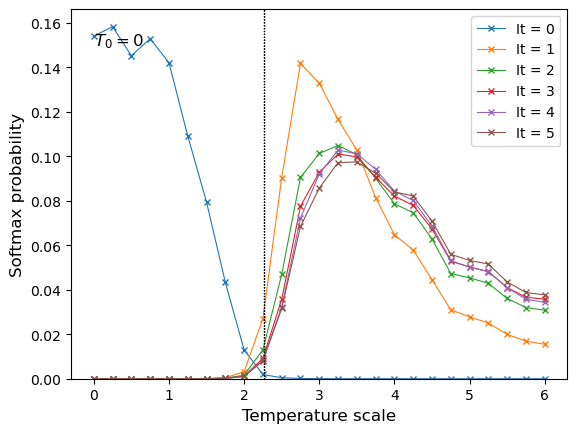

In [26]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_100,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

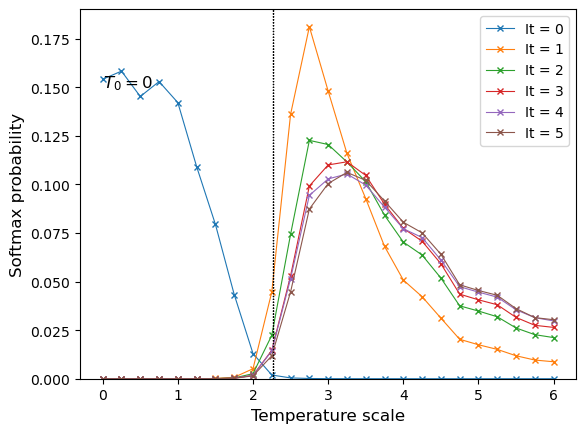

In [27]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_200,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

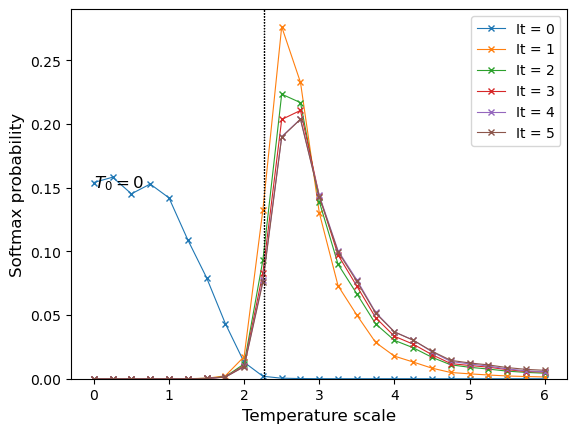

In [28]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_400,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

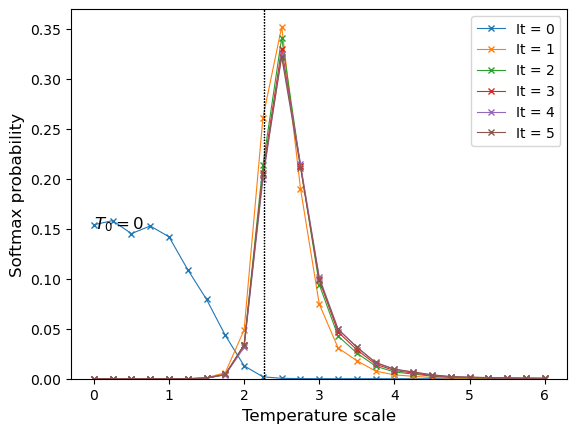

In [29]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_800,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

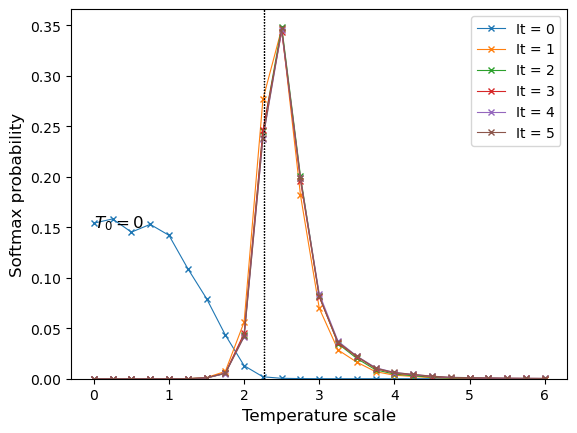

In [30]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_1600,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

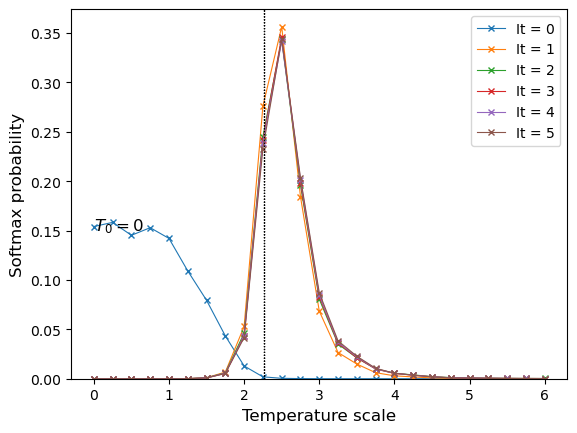

In [31]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_3200,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

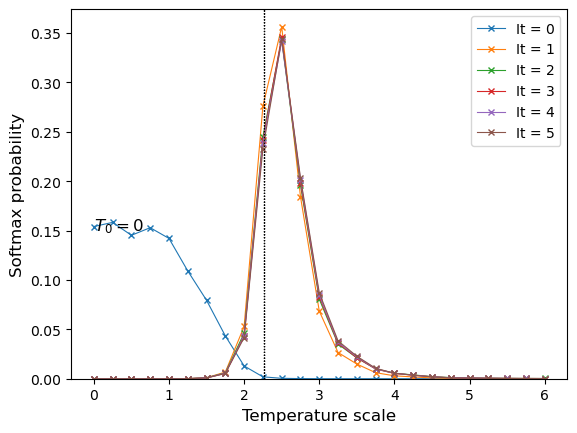

In [32]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_6400,
            ising_data,
            L= 10,
            x= 35,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

In [13]:
# execute the flow method from the RBM object, using 40 iterations and initalise state v0
# so it starts from 1000 10x10 configurations with all 1's...
# then goes through 40 flow passes/layers

flow = rbm.flow(n_it_flow= 40, vk= v0)

In [80]:
flow1000 = rbm1000.flow(n_it_flow= 40, vk= v0)

In [88]:
flow800 = rbm800.flow(n_it_flow= 40, vk= v0)

In [89]:
# with open(f'rbm_L{L}_flow_ALL_Tin_zero_it1.pkl', 'wb') as f:
    # pickle.dump(flow, f)

In [90]:
# with open('rbm_flow_L010_ALL_Tin_zero_it2.pkl', 'wb') as f:
    # pickle.dump(flow1000, f)

In [91]:
# with open('rbm_flow_L010_ALL_Tin_zero_it2.pkl', 'wb') as f:
    # pickle.dump(flow800, f)

In [14]:
with open(f'rbm_L{L}_flow_ALL_Tin_zero_it1.pkl', 'rb') as f:
    flow = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'rbm_L11_flow_ALL_Tin_zero_it1.pkl'

In [93]:
#with open('rbm_flow_L010_ALL_Tin_zero_it2.pkl', 'rb') as f:
    #flow1000 = pickle.load(f)

In [94]:
#with open('rbm_flow_L010_ALL_Tin_zero_it2.pkl', 'rb') as f:
    # flow800 = pickle.load(f)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [15]:

with open(f'rbm_L{L}_flow_ALL_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [16]:
with open(f'rbm_L{L}_flow_ALL_Tin_zero_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [17]:
# create a list 'flow_' that contains all elements in the 'flow' object
flow_ = [ x for x in flow ]

In [98]:
flow_1000 = [ x for x in flow1000 ]

In [99]:
flow_800 = [ x for x in flow800 ]

In [100]:
print(np.shape(flow_[0]))

torch.Size([1000, 100])


In [70]:
len(flow_) # so now we have 40 10x10 configurations (1 for each pass/layer of rmb flow)
# note there is 1000 samples for each configuration

41

In [71]:
# seems to converge quickly to a steady state. we must investigate the placement of
# 1's and 0's relative to one another to determine the temperature

In [72]:
plt.plot(box2)

NameError: name 'box2' is not defined

Temperature measurement in the defined temperature scale.

In [18]:
# here i will try find the temperature change for each iteration
# i will adjust the thermometer function to return just temperature at each layer
def thermometer2(flow_,
                ising_data,
                L= L,
                x= 0,
                step= 2,
                save= False,
                Tzero= True, 
                x_text= 0,
                y_text= 0.15,
                errorbar= True,
                publication= False,
                training_set= 'COMPLETE',
                loc_legend= 'lower right',
                NN_path= f'L{L}_NN_Ising2D_MC.pt'): # this points to the trained NN thermometer
    
    net = Net()
    net = torch.load(NN_path)  

    box = []
    info = []
    for j in range(0, len(flow_) - x, step):
        
        prediction = net(flow_[j])
        box.append(prediction)
        info.append(np.shape(flow_[j]))
    
    # WHY IS BOX LENGTH 6 AND NOT 40?
    # WHY IS INFO LENGTH 6?
        
    return box


In [19]:
# here i will call the thermometer2 fucntion
# investigate this 6 x 1000 x 25 shape, this seems strange
# there's 6 different iterations (0 to 25), 25 different temperatures, 1000 samples for each temp

thermometer2(flow_,
            ising_data,
            L= L,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

[tensor([[1.5412e-01, 1.5830e-01, 1.4524e-01,  ..., 1.0404e-08, 1.0723e-08,
          3.4114e-09],
         [1.5412e-01, 1.5830e-01, 1.4524e-01,  ..., 1.0404e-08, 1.0723e-08,
          3.4114e-09],
         [1.5412e-01, 1.5830e-01, 1.4524e-01,  ..., 1.0404e-08, 1.0723e-08,
          3.4114e-09],
         ...,
         [1.5412e-01, 1.5830e-01, 1.4524e-01,  ..., 1.0404e-08, 1.0723e-08,
          3.4114e-09],
         [1.5412e-01, 1.5830e-01, 1.4524e-01,  ..., 1.0404e-08, 1.0723e-08,
          3.4114e-09],
         [1.5412e-01, 1.5830e-01, 1.4524e-01,  ..., 1.0404e-08, 1.0723e-08,
          3.4114e-09]], grad_fn=<SoftmaxBackward0>),
 tensor([[2.0901e-06, 2.3256e-06, 2.7099e-06,  ..., 1.1872e-06, 8.2494e-07,
          2.8591e-07],
         [1.1444e-06, 1.2751e-06, 1.4792e-06,  ..., 5.7252e-06, 3.1173e-06,
          1.2124e-06],
         [8.6595e-07, 9.6346e-07, 1.0618e-06,  ..., 1.6418e-05, 1.0282e-05,
          4.1151e-06],
         ...,
         [1.9152e-06, 2.0445e-06, 2.3660e-06,  ...,

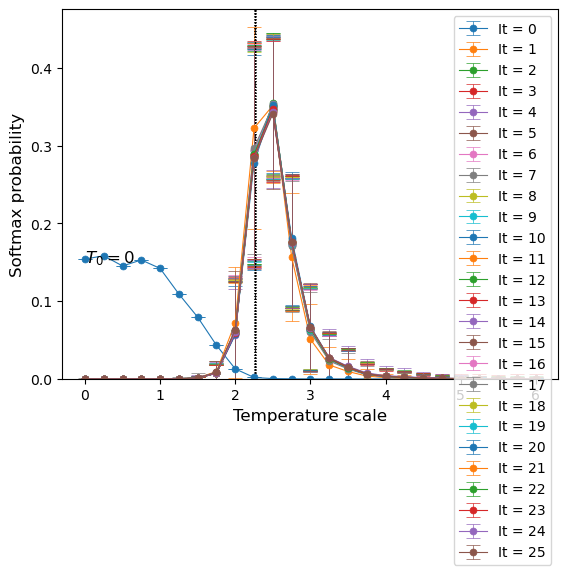

In [20]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_,
            ising_data,
            L= L,
            x= 15,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

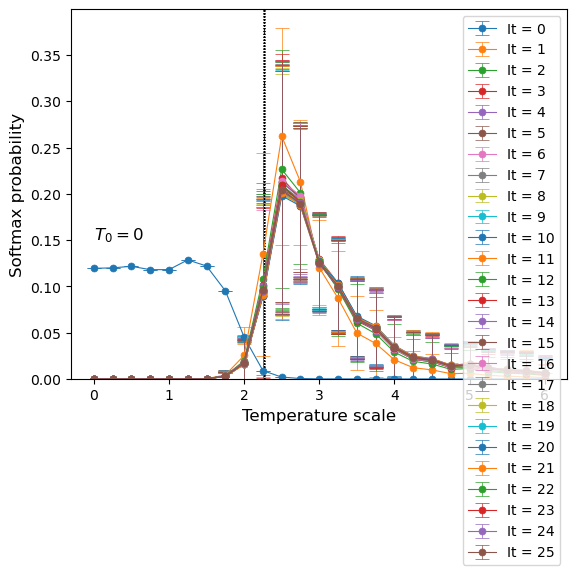

In [45]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_1000,
            ising_data,
            L= L,
            x= 15,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

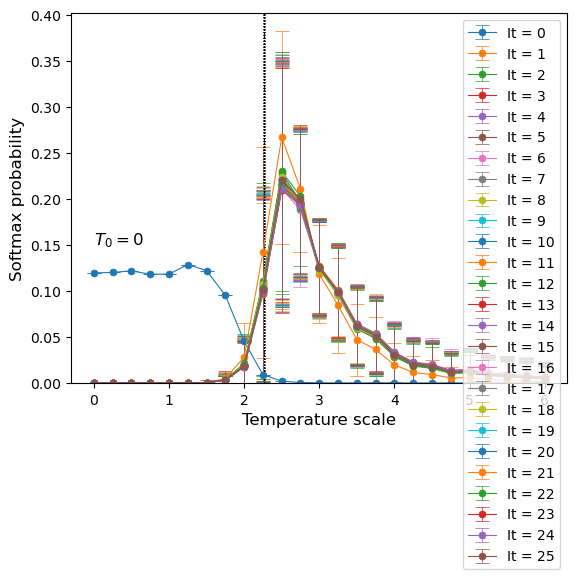

In [101]:
# call the 'thermometer' function with multiple arguments
# call this from wehre
thermometer(flow_800,
            ising_data,
            L= L,
            x= 15,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

Without error bars:

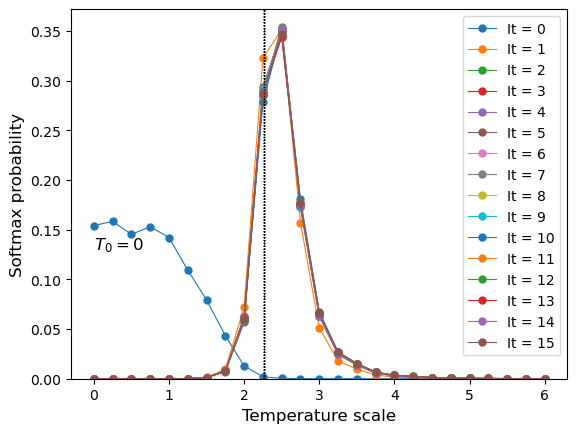

In [21]:
thermometer(flow_,
            ising_data,
            L= L,
            x= 25,
            step= 1,
            Tzero= True,
            x_text= 0,
            y_text= 0.13,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

#### Initial temperature: $T_0 = \infty$

In [25]:
# set grid size to 10 and number of states to 1000

nstates = 1000
# initialise 'up' tensor with half of the total sites, set to 1.0
up = nn.init.constant_(torch.empty(int(L*L/2)+1), val= 1.0)
# initialise 'down' tensor with other half of the total sites, set to 0.0
down = nn.init.constant_(torch.empty(int(L*L/2)), val= 0.0)
# concatenate 'up' and 'down' tensors to form 'up_down'
up_down = torch.cat((up,down), 0)
# reshape 'up_down' and initialise 'v0' with this initial configuration
v0 = up_down.reshape(1, up_down.shape[0])
# loop to create 'nstates' initialise 'v0' with this initial configuration
for j in range(nstates - 1):
    # shuffle 'up_down'
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    # concatenate the new state to 'v0'
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [26]:
# execute the flow method from the RBM object, using 40 iterations and initial state v0
flow100 = rbm100.flow(n_it_flow= 40, vk= v0)
flow200 = rbm200.flow(n_it_flow= 40, vk= v0)
flow400 = rbm400.flow(n_it_flow= 40, vk= v0)
flow800 = rbm800.flow(n_it_flow= 40, vk= v0)
flow1600 = rbm1600.flow(n_it_flow= 40, vk= v0)
flow3200 = rbm3200.flow(n_it_flow= 40, vk= v0)
flow6400 = rbm6400.flow(n_it_flow= 40, vk= v0)

In [27]:
with open('rbm_flow_L11_ALL_Tin_inf_100.pkl', 'wb') as f:
    pickle.dump(flow100, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_100.pkl', 'rb') as f:
    flow100 = pickle.load(f)

flow_100 = [ x for x in flow100 ]

In [28]:
with open('rbm_flow_L11_ALL_Tin_inf_200.pkl', 'wb') as f:
    pickle.dump(flow200, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_200.pkl', 'rb') as f:
    flow200 = pickle.load(f)

flow_200 = [ x for x in flow200 ]

In [29]:
with open('rbm_flow_L11_ALL_Tin_inf_400.pkl', 'wb') as f:
    pickle.dump(flow400, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_400.pkl', 'rb') as f:
    flow400 = pickle.load(f)

flow_400 = [ x for x in flow400 ]

In [30]:
with open('rbm_flow_L11_ALL_Tin_inf_800.pkl', 'wb') as f:
    pickle.dump(flow800, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_800.pkl', 'rb') as f:
    flow800 = pickle.load(f)

flow_800 = [ x for x in flow800 ]

In [31]:
with open('rbm_flow_L11_ALL_Tin_inf_1600.pkl', 'wb') as f:
    pickle.dump(flow1600, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_1600.pkl', 'rb') as f:
    flow1600 = pickle.load(f)

flow_1600 = [ x for x in flow1600 ]

In [32]:
with open('rbm_flow_L11_ALL_Tin_inf_3200.pkl', 'wb') as f:
    pickle.dump(flow3200, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_3200.pkl', 'rb') as f:
    flow3200 = pickle.load(f)

flow_3200 = [ x for x in flow3200 ]

In [33]:
with open('rbm_flow_L11_ALL_Tin_inf_6400.pkl', 'wb') as f:
    pickle.dump(flow6400, f)
    
with open('rbm_flow_L11_ALL_Tin_inf_6400.pkl', 'rb') as f:
    flow6400 = pickle.load(f)

flow_6400 = [ x for x in flow6400 ]

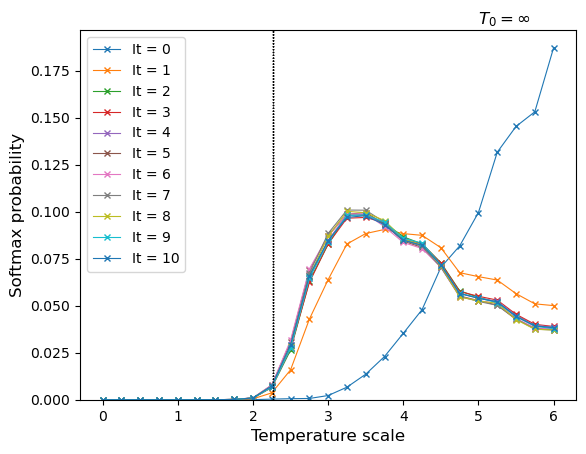

In [34]:
thermometer(flow_100,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

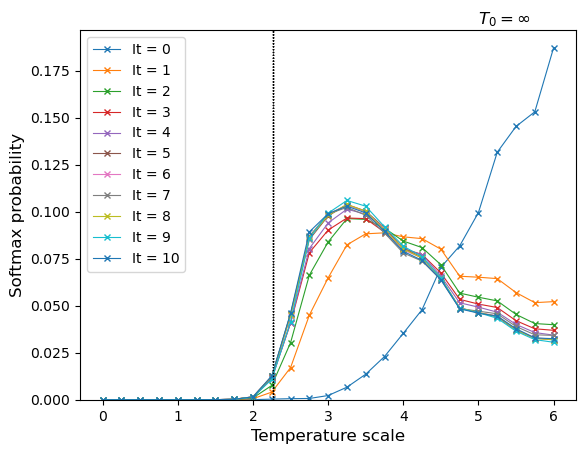

In [35]:
thermometer(flow_200,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

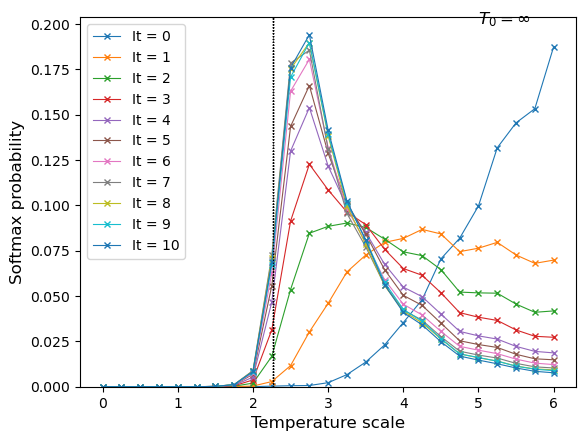

In [36]:
thermometer(flow_400,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

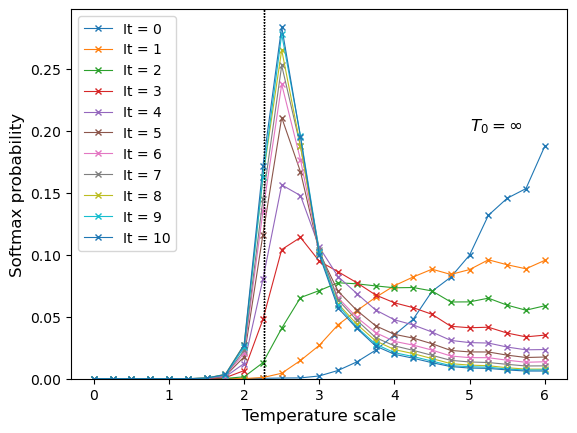

In [37]:
thermometer(flow_800,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

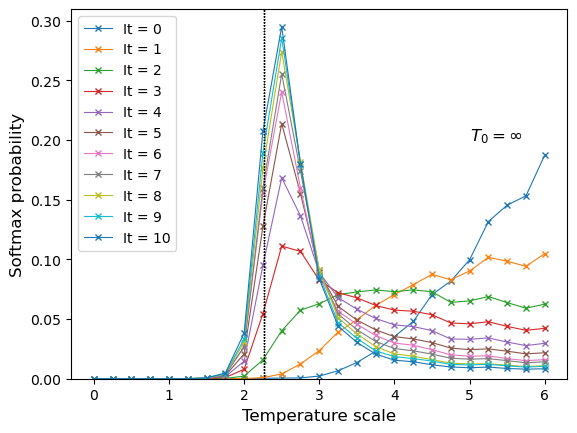

In [38]:
thermometer(flow_1600,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

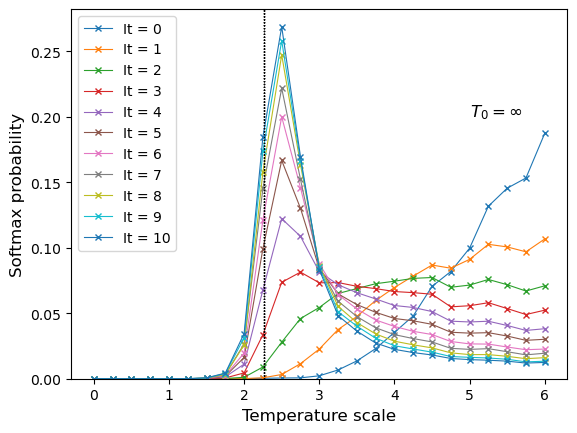

In [39]:
thermometer(flow_3200,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

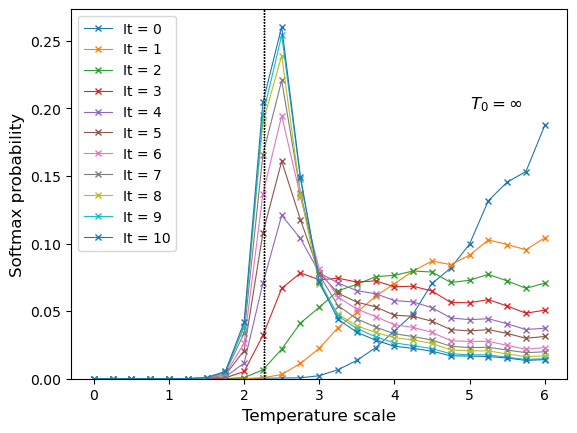

In [40]:
thermometer(flow_6400,
            ising_data,
            L= 10,
            x= 30,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= True,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'L11_NN_Ising2D_MC.pt')

In [41]:
# execute the flow method from the RBM object, using 40 iterations and initial state v0
flow = rbm.flow(n_it_flow= 40, vk= v0)

NameError: name 'rbm' is not defined

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [24]:
with open(f'rbm_L{L}_flow_ALL_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [25]:
with open(f'rbm_L{L}_flow_ALL_Tin_inf_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [26]:
flow__ = [ x for x in flow ]

Temperature measurement in the defined temperature scale.

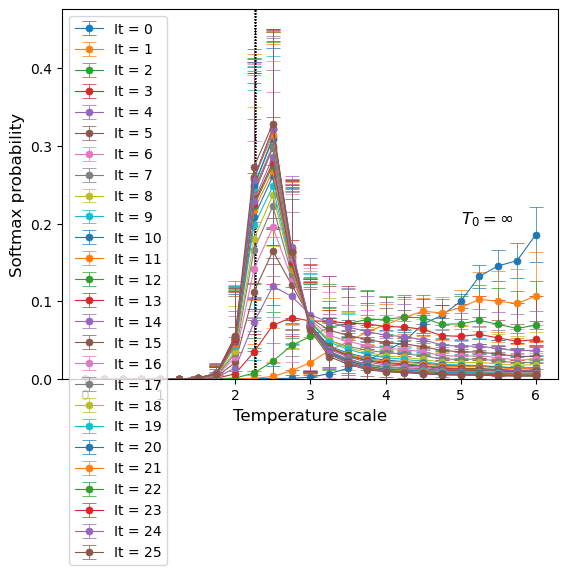

In [27]:
thermometer(flow__,
            ising_data,
            L= L,
            x= 15,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

Without error bars:

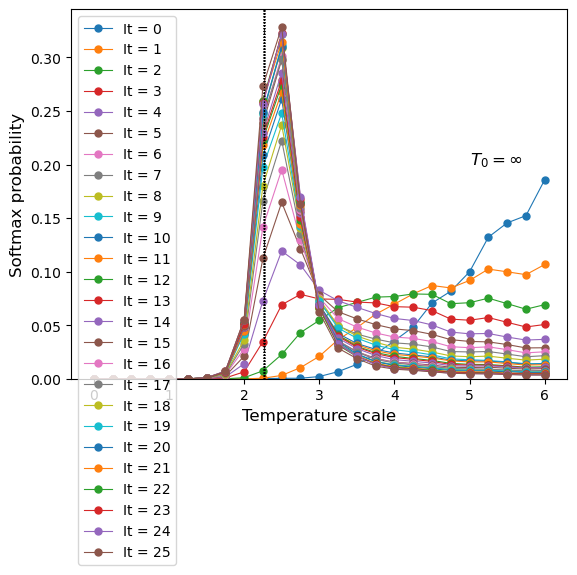

In [28]:
thermometer(flow__,
            ising_data,
            L= L,
            x= 15,
            step= 1,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= f'L{L}_NN_Ising2D_MC.pt')

#### Initial temperatures $T_0 = 0$ and $T_0 = \infty$ plots in the same figure

We can also take a look at the flows from $T_0 = 0$ and $T_0 = \infty$ in the same figure. 

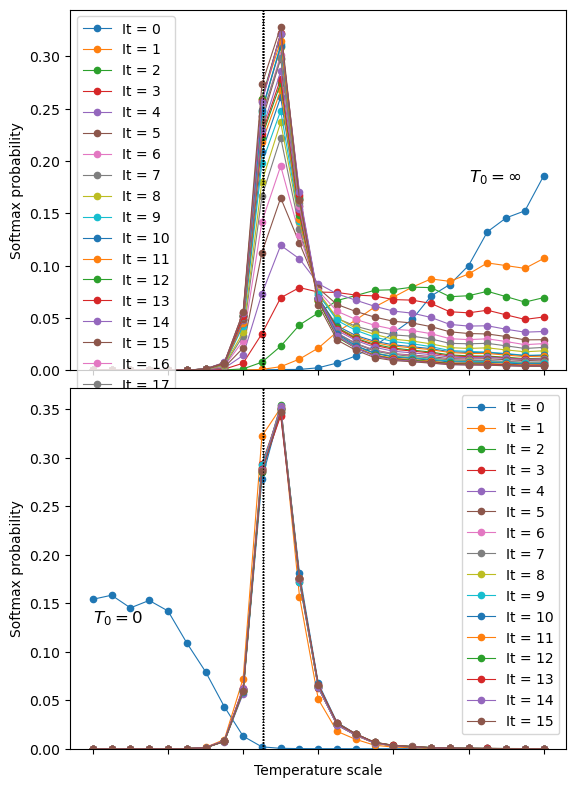

In [29]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= L,
                       x1= 15,
                       x2= 25,
                       step1= 1,
                       step2= 1,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 5.0,
                       y_text1= 0.18,
                       x_text2= 0.0,
                       y_text2= 0.13,
                       errorbar1= False,
                       errorbar2= False,
                       publication= False,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'COMPLETE',
                       NN_path= f'L{L}_NN_Ising2D_MC.pt')

We can also plot both flows from $T_0 = 0 $ and $ T_0 = \infty$ in the same figure with error bars on the first and last flows.

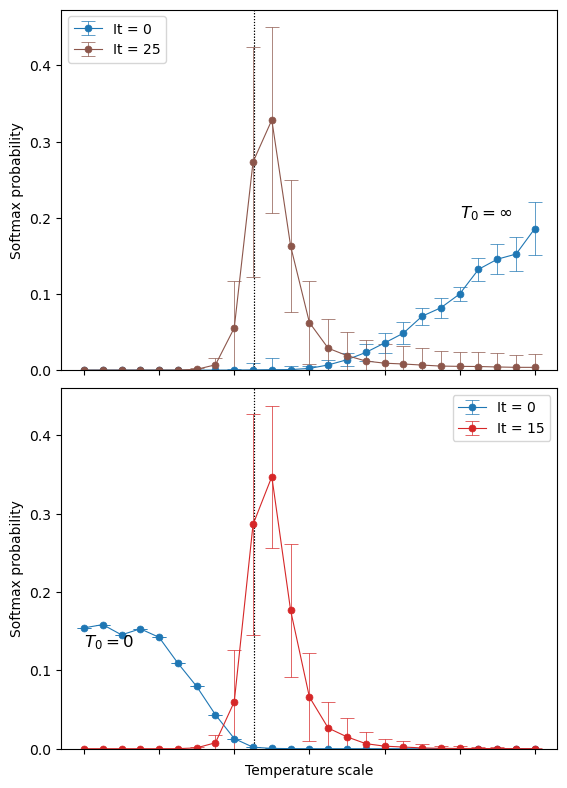

In [30]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= L,
                       x1= 15,
                       x2= 25,
                       step1= 25,
                       step2= 15,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 5.0,
                       y_text1= 0.2,
                       x_text2= 0.0,
                       y_text2= 0.13,
                       errorbar1= True,
                       errorbar2= True,
                       publication= False,
                       ref_other_plot= True,
                       step1_ref_other= 5,
                       step2_ref_other= 5,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'COMPLETE',
                       NN_path= f'L{L}_NN_Ising2D_MC.pt')

#### Magnetization dynamics

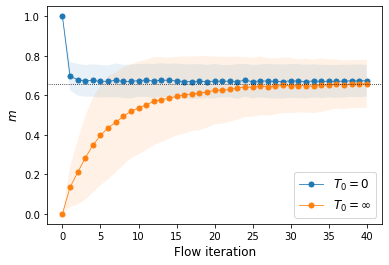

m^{*} = 0.658280


In [28]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= L,
              errorbar= False,
              fill_error= True, 
              Tzero= True,
              x = 0,
              save= True,
              training_set= 'COMPLETE',
              publication= False)

### Flow from RBM trained with $T = 4, 4.25, ..., 5.75, 6 $.

Since the training set has only states with temperature greater than the critical one, the RBM flow does not go towards the critical temperauter of the Ising model in a square lattice with no external field.

First we load the trained RBM model.

# STOP HERE

In [38]:
rbm = RBM()
rbm = torch.load('RBM_model_T_H_high_nv100_nh100_lr1.0E-02_k1_bsize100_nepochs5000.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'RBM_model_T_H_high_nv100_nh100_lr1.0E-02_k1_bsize100_nepochs5000.pt'

For the sake of completeness, we take a look at the weights distribution.

In [30]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

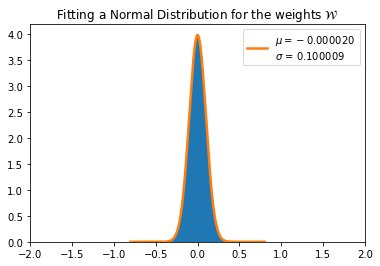

In [31]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 500, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_H, sigmaW_H = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_H, sigmaW_H) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_H, sigmaW_H ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-2, 2])
plt.legend()
plt.show()

We can also take a look at the matrix ${\cal W} {\cal W}^{T}$:

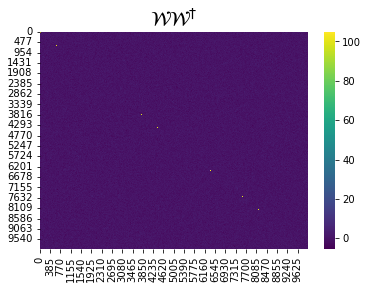

In [32]:
WW = torch.mm(W.t(), W)
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
plt.show()

In [33]:
del W
torch.cuda.empty_cache()

#### Initial temperature: $T_0= 0$

In [34]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [35]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x100 and 10000x10000)

Perhaps we will be needing this flow for further analysis, then we save it in a pickle file.

In [42]:
with open('RBM_flows/rbm_flow_L010_ONLY_THigh_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

FileNotFoundError: [Errno 2] No such file or directory: 'RBM_flows/rbm_flow_L010_ONLY_THigh_Tin_zero_it040.pkl'

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [314]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

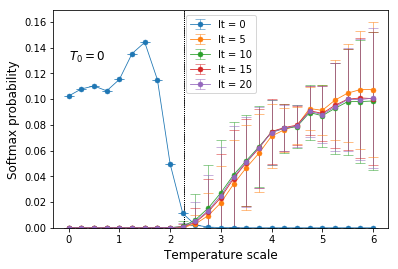

In [328]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 20,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.13,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper center',
            training_set= 'HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

In [ ]:
Without error bars:

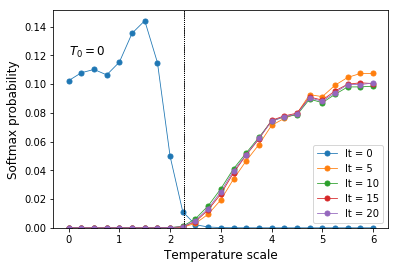

In [336]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 20,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.12,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'lower right',
            training_set= 'HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Initial temperature: $T_0 = \infty$

In [319]:
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [320]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [321]:
with open('RBM_flows/rbm_flow_L010_ONLY_THigh_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [322]:
flow__ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

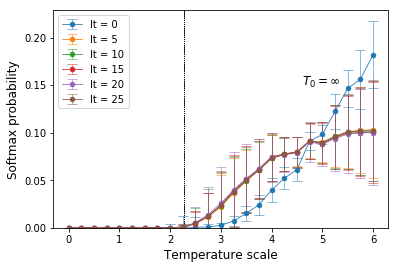

In [331]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 4.6,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

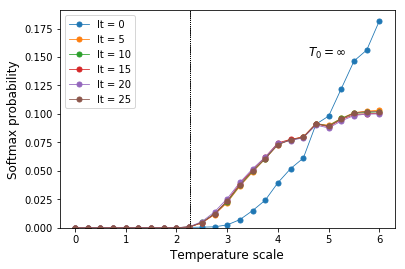

In [332]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 4.6,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Magnetization dynamics

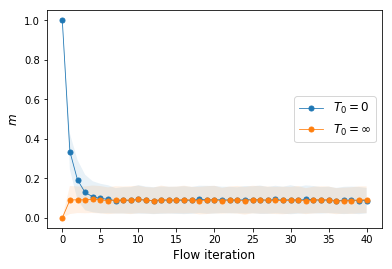

In [339]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 10,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'center right',
              training_set= 'HIGH',
              publication= False)

### Flow from RBM trained only with  $T = 10^{-6} $.

Since the training set has only states with temperature less than the critical one, the RBM flow does not go towards the critical temperature of the Ising model in a square lattice with no external field.


First we load the trained RBM model.

In [283]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_L_low_nv100_nh100_lr1.0E-02_k1_bsize100_nepochs5000.pt')

For the sake of completeness, we take a look at the weights distribution.

In [11]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

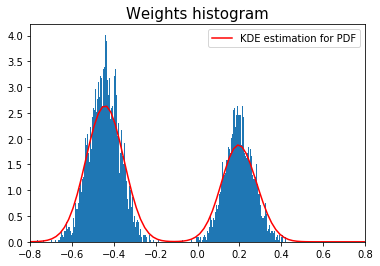

In [12]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

kde0 = stats.gaussian_kde(W_ , bw_method= None)


x_eval = np.linspace(-1, 1, num= 100)
plt.plot(x_eval, kde0(x_eval), 'r-', label= 'KDE estimation for PDF')
plt.hist(W_,
         bins= 500,
         density= True)
plt.legend()
plt.title('Weights histogram', fontsize= 15)
plt.xlim([-0.8, 0.8])
plt.show()

We can also take a look at the matrix ${\cal W} {\cal W}^{T}$:

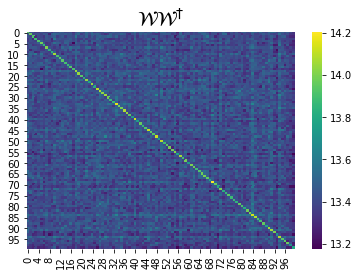

In [25]:
WW = torch.mm(W.t(), W)
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
plt.show()

In [26]:
del W
torch.cuda.empty_cache()

#### Initial temperature: $T_0= 0$

In [284]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [285]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, then we save it in a pickle file.

In [286]:
with open('RBM_flows/rbm_flow_L010_ONLY_TLow_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [287]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

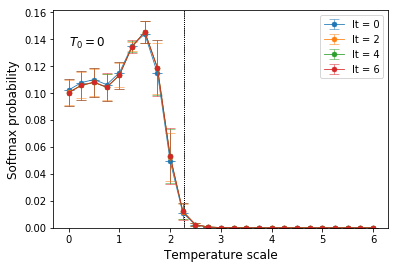

In [291]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 34,
            step= 2,
            Tzero= True,
            x_text= 0,
            y_text= 0.135,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

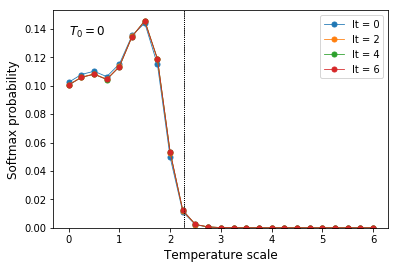

In [292]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 34,
            step= 2,
            Tzero= True,
            x_text= 0,
            y_text= 0.135,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Initial temperature: $T_0 = \infty$

In [293]:
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [294]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [295]:
with open('RBM_flows/rbm_flow_L010_ONLY_TLow_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [296]:
flow__ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

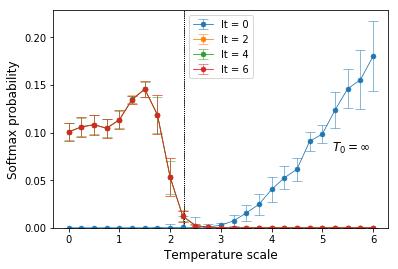

In [300]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 34,
            step= 2,
            Tzero= False,
            x_text= 5.2,
            y_text= 0.08,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper center',
            training_set= 'LOW',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

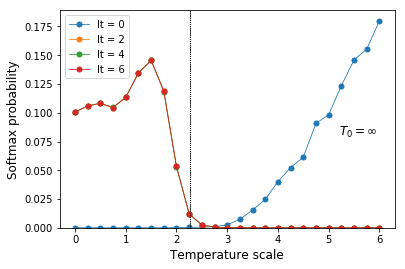

In [303]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 34,
            step= 2,
            Tzero= False,
            x_text= 5.2,
            y_text= 0.08,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Magnetization dynamics

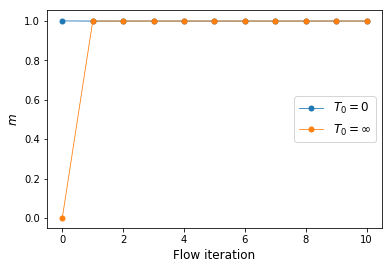

In [309]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 10,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 30,
              save= False, 
              loc_legend= 'center right',
              training_set= 'LOW',
              publication= False)

### Flow from RBM trained only with $T=0$ and $ T = \infty$

In order to investigate the RBM flow in an extreme situation, we have trained the machine in an dataset composed only by frozen and random states. 

It is crucial to note that, since the visible layer is always fed with an unidimensional vector (an array is transformed in a vector to be fed in the visible layer), the machine does not have any geometric information about the lattice in this case.

First we load the trained RBM model.

In [241]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_zero_inf_nv100_nh100_lr1.0E-02_k1_bsize100_nepochs30000.pt')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'rbm.RBM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


For the sake of completeness, we take a look at the weights distribution.

In [14]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

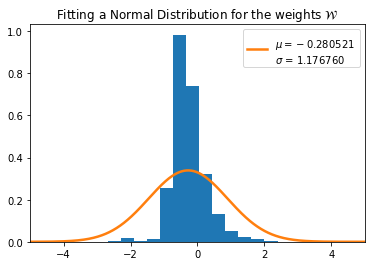

In [15]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 200, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_HL, sigmaW_HL = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_HL, sigmaW_HL) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_HL, sigmaW_HL ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-5, 5])
plt.legend()
plt.show()

We can also take a look at the matrix ${\cal W} {\cal W}^{T}$:

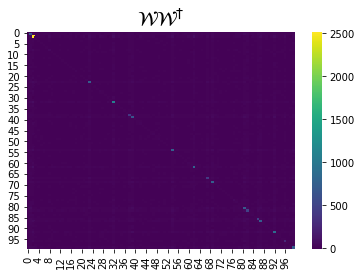

In [60]:
WW = torch.mm(W.t(), W)
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
plt.show()

#### Initial temperature: $T_0= 0$

In [242]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [243]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, then we save it in a pickle file.

In [40]:
with open('RBM_flows/rbm_flow_L010_ONLY_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

FileNotFoundError: [Errno 2] No such file or directory: 'RBM_flows/rbm_flow_L010_ONLY_Tin_zero_it040.pkl'

In [41]:
with open('RBM_flows/rbm_flow_L010_ONLY_Tin_zero_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'RBM_flows/rbm_flow_L010_ONLY_Tin_zero_it040.pkl'

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [343]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

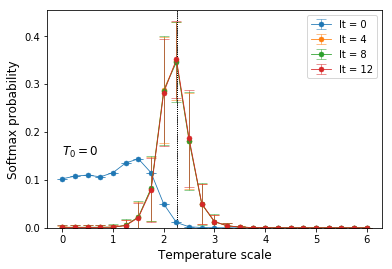

In [256]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 28,
            step= 4,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

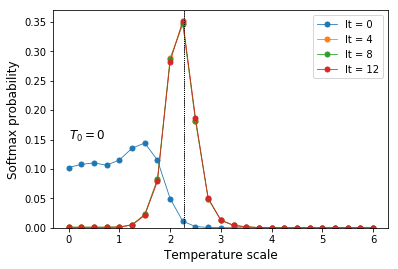

In [264]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 28,
            step= 4,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Initial temperature: $T_0 = \infty$

In [257]:
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [258]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [259]:
with open('RBM_flows/rbm_flow_L010_ONLY_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [344]:
with open('RBM_flows/rbm_flow_L010_ONLY_Tin_inf_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [345]:
flow__ = [ x.cuda() for x in flow ]

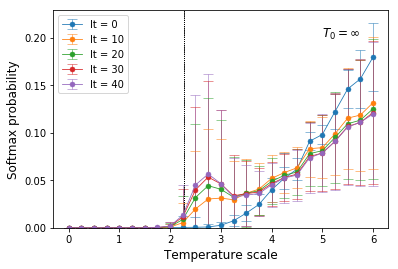

In [263]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 0,
            step= 10,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

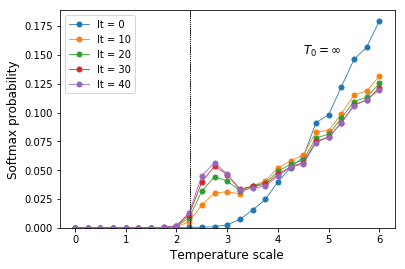

In [266]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 0,
            step= 10,
            Tzero= False,
            x_text= 4.5,
            y_text= 0.15,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Magnetization dynamics

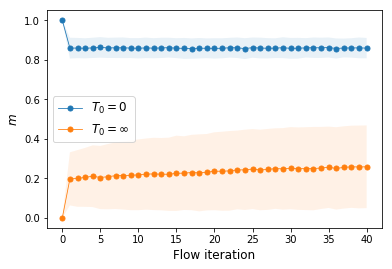

In [347]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 10,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'center left',
              training_set= 'LOW_HIGH',
              publication= False)

### Flow from RBM trained  with 25 different temperatures (MEAN FIELD)

First we load the trained RBM model.

In [7]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_complete_MF_nv100_nh100_lr1.0E-03_k1_bsize100_nepochs20000.pt')

For the sake of completeness, we take a look at the weights distribution.

In [8]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

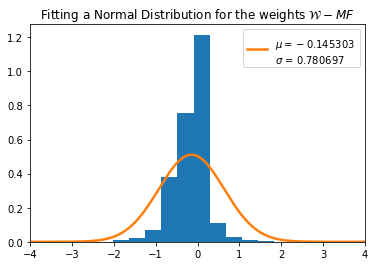

In [9]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 100, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_MF, sigmaW_MF = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_MF, sigmaW_MF) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_MF, sigmaW_MF ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}- MF$')
plt.xlim([-4, 4])
plt.legend()
plt.show()

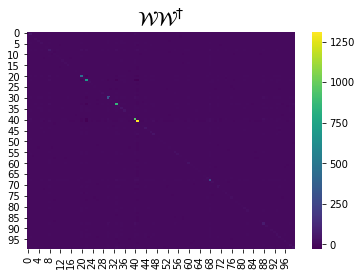

In [10]:
WW = torch.mm(W.t(), W) # WW^T 
sns.heatmap(WW, linewidths= 0.0, cmap= 'viridis')
plt.title('${\cal W} {\cal W}^{\dag}$', fontsize= 20)
plt.show()

In [11]:
del W
torch.cuda.empty_cache()

#### Initial temperature: $T_0= 0$

In [12]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [13]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [21]:
with open('RBM_flows/rbm_flow_L010_MF_ALL_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [6]:
with open('RBM_flows/rbm_flow_L010_MF_ALL_Tin_zero_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [7]:
flow_ = [ x.cuda() for x in flow ]

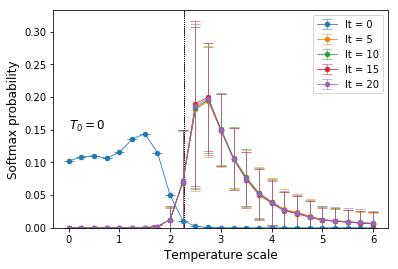

In [20]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 20,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

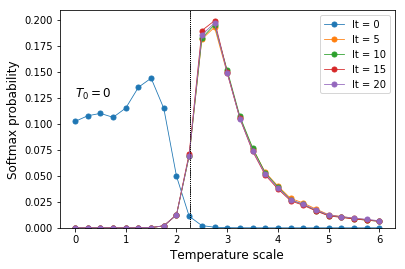

In [33]:
thermometer(flow_,
            ising_data,
            L= 10,
            x= 20,
            step= 5,
            Tzero= True,
            x_text= 0,
            y_text= 0.125,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Initial temperature: $T_0 = \infty$

In [22]:
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [23]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [24]:
with open('RBM_flows/rbm_flow_L010_MF_ALL_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [8]:
with open('RBM_flows/rbm_flow_L010_MF_ALL_Tin_inf_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [9]:
flow__ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

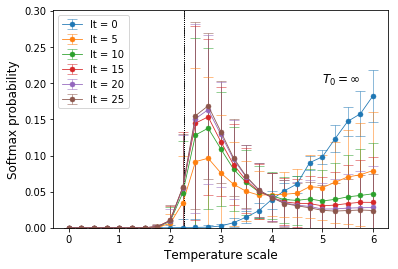

In [29]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

Without error bars:

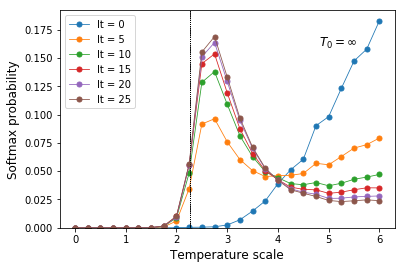

In [32]:
thermometer(flow__,
            ising_data,
            L= 10,
            x= 15,
            step= 5,
            Tzero= False,
            x_text= 4.8,
            y_text= 0.16,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt')

#### Magnetization dynamics

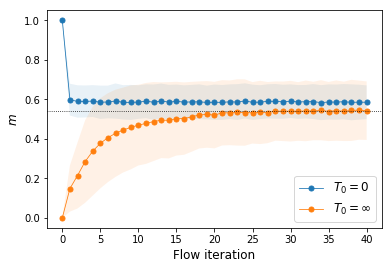

m^{*} = 0.542560


In [11]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 10,
              errorbar= False,
              fill_error= True, 
              Tzero= True,
              x = 0,
              save= False,
              training_set= 'MF',
              publication= False)

## Comparison between weight distributions

Now we compare the weight distribution from the four trained RBMs. The following two cells just set some plot convenient plot values. 

In [143]:
publication= False
save = False

In [144]:
if publication:
    fontsize_lg = 3.0
    linewidth= 0.5
    figsize= (3.375, 0.678*3.375)
    fontsize_t = 3.0
    linewidth_v = 0.3
    axis_width = 0.5
    
    if save:
        
        path_fig = 'figures/PUB_W_distrib_L%d.pdf' % L
        
else:
    
                 
    fontsize_lg = 13.0
    linewidth= 2.0
    figsize= (15, 10)
    fontsize_t = 12.0
    linewidth_v = 1.0
    axis_width = 1.0
        
    if save:
                
        path_fig = 'figures/W_distrib_L%d.pdf' % L

The four distributions are compared in a a figure constructed with [matplotlib.pyplot.subplots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html).

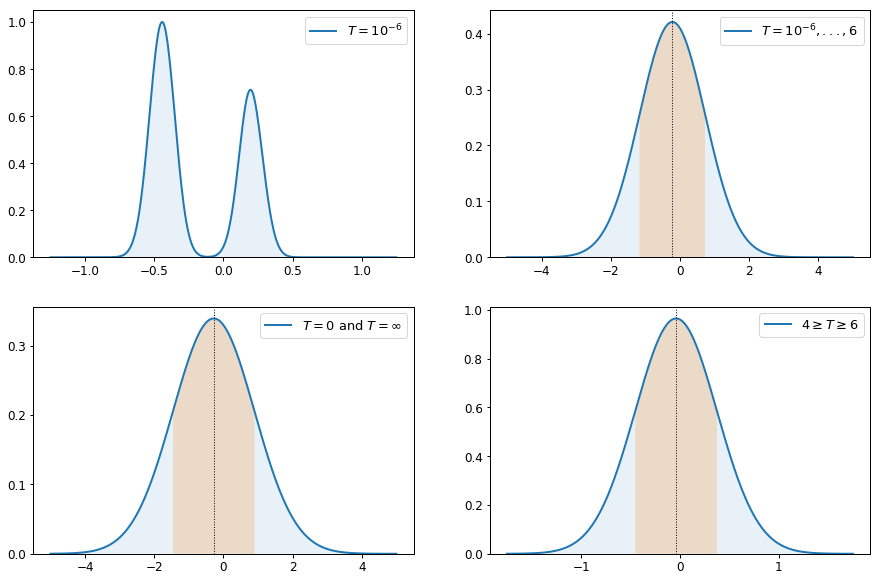

In [145]:
f, axs = plt.subplots(2, 2,
                      figsize= figsize)


x_L = np.linspace(-1.25, 1.25, 500)
x_HL = np.linspace(-5, 5, 500)
x_H = np.linspace(-1.75, 1.75, 500)
x_V = np.linspace(-5, 5, 500)

#######################

axs[0, 0].plot(x_L,
               kde0(x_L) / max(kde0(x_L)),
               linewidth= linewidth,
               label= '$ T = 10^{-6}$')


axs[0, 0].fill_between(x_L,
                       kde0(x_L) / max(kde0(x_L)),
                       0,
                       alpha=0.1)

axs[0, 0].set_ylim([0.0, axs[0, 0].set_ylim()[1]])
axs[0, 0].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[0, 0].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[0, 0].locator_params(axis='y', nbins=6)
axs[0, 0].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[0, 0].spines[axis].set_linewidth(axis_width)
    

#######################


axs[0, 1].plot(x_V,
               stats.norm.pdf(x_V, muW_V, sigmaW_V), 
               linewidth= linewidth,
               label= '$T=10^{-6}, ..., 6$')

axs[0, 1].axvline(x= muW_V, linestyle= ':', linewidth= linewidth_v, color= 'black')

axs[0, 1].fill_between(x_V,
                       stats.norm.pdf(x_V, muW_V, sigmaW_V),
                       0, 
                       alpha=0.1)

x_percentil_V = np.linspace(muW_V - sigmaW_V, muW_V + sigmaW_V, 500) 

axs[0, 1].fill_between(x_percentil_V,
                       stats.norm.pdf(x_percentil_V, muW_V, sigmaW_V),
                       0, 
                       alpha=0.2)

axs[0, 1].set_ylim([0.0, axs[0, 1].set_ylim()[1]])
axs[0, 1].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[0, 1].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[0, 1].locator_params(axis='y', nbins=6)
axs[0, 1].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[0, 1].spines[axis].set_linewidth(axis_width)

#################


axs[1, 0].plot(x_HL, 
               stats.norm.pdf(x_HL, muW_HL, sigmaW_HL), 
               linewidth= linewidth,
               label= '$T=0$ and $T=\infty$')

axs[1, 0].axvline(x= muW_HL, linestyle= ':', linewidth= linewidth_v, color= 'black')

axs[1, 0].fill_between(x_HL, 
                       stats.norm.pdf(x_HL, muW_HL, sigmaW_HL),
                       0, 
                       alpha=0.1)

x_percentil_L = np.linspace(muW_HL - sigmaW_HL, muW_HL + sigmaW_HL, 500) 

axs[1, 0].fill_between(x_percentil_L, 
                       stats.norm.pdf(x_percentil_L, muW_HL, sigmaW_HL),
                       0, 
                       alpha=0.2)

axs[1, 0].set_ylim([0.0, axs[1, 0].set_ylim()[1]])
axs[1, 0].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[1, 0].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[1, 0].locator_params(axis='y', nbins=6)
axs[1, 0].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[1, 0].spines[axis].set_linewidth(axis_width)


#########################

axs[1, 1].plot(x_H, 
               stats.norm.pdf(x_H, muW_H, sigmaW_H), 
               linewidth= linewidth,
               label= '$ 4 \geq T \geq 6$')

axs[1, 1].axvline(x= muW_H, linestyle= ':', linewidth= linewidth_v, color= 'black')

axs[1, 1].fill_between(x_H, 
                       stats.norm.pdf(x_H, muW_H, sigmaW_H),
                       0, 
                       alpha=0.1)

x_percentil_H = np.linspace(muW_H - sigmaW_H, muW_H + sigmaW_H, 500) 

axs[1, 1].fill_between(x_percentil_H, 
                       stats.norm.pdf(x_percentil_H, muW_H, sigmaW_H),
                       0, 
                       alpha=0.2)

axs[1, 1].set_ylim([0.0, axs[1, 1].set_ylim()[1]])
axs[1, 1].tick_params(axis="x", labelsize= fontsize_t, width= axis_width)
axs[1, 1].tick_params(axis="y", labelsize= fontsize_t, width= axis_width)
axs[1, 1].locator_params(axis='x', nbins=7)
axs[1, 1].legend(fontsize= fontsize_lg)

for axis in ['top','bottom','left','right']:
    axs[1, 1].spines[axis].set_linewidth(axis_width)


if save:
    plt.savefig(path_fig , bbox_inches='tight')

plt.show()